 # <center> Identifying Turnover in Mortgage Prepayments <center>
## <center> US Bank, IMA Math to Industry Boot Camp 2022 <center>
### <center> Caroline Bang, Katheryn Beck, Zanbing Dai, Leo Digiosia, Arpan Pal <center>

U.S. agency 1 residential mortgage-backed securities (MBS) are the largest and most liquid securitized asset class in the world. Banks, insurance companies, and money managers invest in MBS because they provide an attractive yield relative to U.S. Treasury securities with comparable credit risk. However, unlike most fixed income securities, which have specified contractual coupon and principal payments, the timing and amount of MBS cash flows is uncertain. This is because MBS are pools of individual mortgages on which the borrower has the right to prepay the loan at any given time during the life of the loan. Prepayment risk, which impacts the yield and interest rate risk of an MBS comes from five sources:

 - Rate/term refinance which occur when borrowers lower interest payments or shorten the term of the current mortgage.
 - Cash-out refinance which involve extracting equity from a home.
 - Involuntary buyouts, which in the case of agency MBS result in an early return of principal. However, the timing is contingent on the GSEs or GNMA loan servicers.
 - Curtailments, which are partial prepayment or full payoff before maturity.
 - Turnover, which is caused by geographic migration and home upgrades. Turnover creates a baseline level of prepayments that are highly seasonal.

The COVID-19 crisis and response by the Federal Reserve resulted in a low-rate environment that elevated both levels of refinance and buyout activity. Since the initiation of quantitative tightening, sustained inflation, and rising interest rates, refinance activity has slowed considerably. At present, a major question affecting the risk profile of MBS is to what extent prepayment activity will decrease. With diminishing refinance incentives, the major sources of prepayment are now turnover, curtailment, and buyouts. As a baseline level of prepayment activity, understanding turnover is important to evaluating the risks of mortgage-backed securities. The goal of this project is to use loan-level mortgage data and macroeconomic data to quantify turnover prepayment speed.

---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------

# (1) Using incentives to distinguish refinancing from turnover

Turnover and refinancing are the most common reasons for mortgage prepayment. Associated to a pool of mortgages are two quantities:

 - CPR, The *Conditional prepayment rate*. This is a percentage describing what proportion of the loan pool is being paid ahead of schedule per year. A high CPR indicates that many mortgages in a given pool are experiencing prepayment
 - WAC, the *Weighted Average Coupon* associated to the pool describes the average mortgage rate over all loans.
 
Given a mortgage pool with its associated WAC, we can compute its **refinance incentive**: 

$$\text{incentive} = \text{WAC} - \text{Mortgage},$$

where the Mortgage term describes the mortgage rate that borrowers in the pool could obtain by refinancing their mortgage. Thus, when this difference is high and positive, we expect that borrowers will take the incentive, refinance their mortgage, and pay off their existing mortgage in full, contributing to an increase in CPR for that pool. When the incentive is negative, we assume that borrowers who pay their mortgage in full are not doing so due to refinancing, but instead, due to turnover.

Below, we explore relationships between available mortgage rates, refinance incentives, and CPR of mortgage pools, for groups of borrowers filtered by credit score (FICO) and LTV ratios of mortgages. We say a *high* FICO score is one greater than 740, and a *low* FICO score is below 680. A *high* LTV ratio is one above 80, and a *low* LTV ratio is one below 80.

In [52]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.optimize as opt
import warnings
warnings. filterwarnings('ignore')

MonthlyCPR = pd.read_csv('./MonthlyCPRNumericDates.csv')
MonthlyCPR['Date'] = pd.to_datetime(MonthlyCPR['Date'])
MonthlyCPR["Month"] = pd.to_datetime(MonthlyCPR['Date']).dt.month
MonthlyCPR['Year'] = pd.to_datetime(MonthlyCPR['Date']).dt.year
MonthlyCPR = MonthlyCPR.iloc[::-1]
MonthlyCPR94to21 = MonthlyCPR.loc[MonthlyCPR["Year"] <2022 ]
MonthlyCPR15to21 = MonthlyCPR94to21.loc[MonthlyCPR94to21["Year"] >=2015 ]
weeklyMortgageRatesFreddy = pd.read_csv('./MortgageRatesFreddyMac.csv')
weeklyMortgageRatesFreddy = weeklyMortgageRatesFreddy[["Week", "30YrFRM"]]
weeklyMortgageRatesFreddy['Week'] = pd.to_datetime(weeklyMortgageRatesFreddy['Week'])
weeklyMortgageRatesFreddy["Month"] = pd.to_datetime(weeklyMortgageRatesFreddy['Week']).dt.month
weeklyMortgageRatesFreddy["Year"] = pd.to_datetime(weeklyMortgageRatesFreddy['Week']).dt.year
weeklyMortgageRatesFreddy94to21 = weeklyMortgageRatesFreddy.loc[weeklyMortgageRatesFreddy["Year"] >= 1994 ]
weeklyMortgageRatesOB = pd.read_csv('./OB.csv')
weeklyMortgageRatesOB = weeklyMortgageRatesOB[['Week', '30YR', '30YR1A', '30YR1E', '30YR2A', '30YR2E']]
weeklyMortgageRatesOB['Week'] = pd.to_datetime(weeklyMortgageRatesOB['Week'])
weeklyMortgageRatesOB.rename(columns = {'30YR1A':'Rate_LowLTV_LowFICO', 
                                        '30YR1E':'Rate_LowLTV_highFICO',
                                        '30YR2A':'Rate_highLTV_LowFICO', 
                                        '30YR2E':'Rate_highLTV_highFICO',
                                        '30YR':'Rate_All'}, inplace = True)
weeklyMortgageRatesOB['Rate_All'] = weeklyMortgageRatesOB['Rate_All'].str.rstrip("%").astype(float)
weeklyMortgageRatesOB['Rate_LowLTV_LowFICO'] = weeklyMortgageRatesOB['Rate_LowLTV_LowFICO'].str.rstrip("%").astype(float)
weeklyMortgageRatesOB['Rate_LowLTV_highFICO'] = weeklyMortgageRatesOB['Rate_LowLTV_highFICO'].str.rstrip("%").astype(float)
weeklyMortgageRatesOB['Rate_highLTV_LowFICO'] = weeklyMortgageRatesOB['Rate_highLTV_LowFICO'].str.rstrip("%").astype(float)
weeklyMortgageRatesOB['Rate_highLTV_highFICO'] = weeklyMortgageRatesOB['Rate_highLTV_highFICO'].str.rstrip("%").astype(float)
weeklyMortgageRatesOB["Month"] = pd.to_datetime(weeklyMortgageRatesOB['Week']).dt.month
weeklyMortgageRatesOB["Year"] = pd.to_datetime(weeklyMortgageRatesOB['Week']).dt.year
weeklyMortgageRatesOB15to21 = weeklyMortgageRatesOB.loc[weeklyMortgageRatesOB["Year"] <2022 ]
MonthlyCPR94to21["Fred30YrAvG"] = weeklyMortgageRatesFreddy94to21.groupby(['Year', 'Month']).mean()['30YrFRM'].tolist()
MonthlyCPR94to21["incentive_fred"] = MonthlyCPR94to21["FN30WAC"] - MonthlyCPR94to21["Fred30YrAvG"]
MonthlyCPR15to21["Optimal_Blue_Rate"] = weeklyMortgageRatesOB15to21.groupby(['Year', 'Month']).mean()['Rate_All'].tolist()
MonthlyCPR15to21["incentive_OB"] = MonthlyCPR15to21["FN30WAC"] - MonthlyCPR15to21["Optimal_Blue_Rate"]
MonthlyCPR15to21["OB_Rate_LowLTV_LowFICO"] = weeklyMortgageRatesOB15to21.groupby(['Year', 'Month']).mean()['Rate_LowLTV_LowFICO'].tolist()
MonthlyCPR15to21["OB_Rate_LowLTV_highFICO"] = weeklyMortgageRatesOB15to21.groupby(['Year', 'Month']).mean()['Rate_LowLTV_highFICO'].tolist()
MonthlyCPR15to21["OB_Rate_highLTV_LowFICO"] = weeklyMortgageRatesOB15to21.groupby(['Year', 'Month']).mean()['Rate_highLTV_LowFICO'].tolist()
MonthlyCPR15to21["OB_Rate_highLTV_highFICO"] = weeklyMortgageRatesOB15to21.groupby(['Year', 'Month']).mean()['Rate_highLTV_highFICO'].tolist()
FICO_LTV_Refined_WAC_CPR = pd.read_csv('./Cleaned_WAC_CPR.csv')
FICO_LTV_Refined_WAC_CPR['Factor Date'] = pd.to_datetime(FICO_LTV_Refined_WAC_CPR['Factor Date'])
FICO_LTV_Refined_WAC_CPR["Month"] = pd.to_datetime(FICO_LTV_Refined_WAC_CPR['Factor Date']).dt.month
FICO_LTV_Refined_WAC_CPR["Year"] = pd.to_datetime(FICO_LTV_Refined_WAC_CPR['Factor Date']).dt.year
WAC_CPR_LowLTV_LowFICO = FICO_LTV_Refined_WAC_CPR.loc[(FICO_LTV_Refined_WAC_CPR['Orig LTV Description'] == 'LowLTV') & (FICO_LTV_Refined_WAC_CPR['Credit Score Description'] == 'LowFICO')]
WAC_CPR_LowLTV_HighFICO = FICO_LTV_Refined_WAC_CPR.loc[(FICO_LTV_Refined_WAC_CPR['Orig LTV Description'] == 'LowLTV') & (FICO_LTV_Refined_WAC_CPR['Credit Score Description'] == 'HighFICO')]
WAC_CPR_HighLTV_LowFICO = FICO_LTV_Refined_WAC_CPR.loc[(FICO_LTV_Refined_WAC_CPR['Orig LTV Description'] == 'HighLTV') & (FICO_LTV_Refined_WAC_CPR['Credit Score Description'] == 'LowFICO')]
WAC_CPR_HighLTV_HighFICO = FICO_LTV_Refined_WAC_CPR.loc[(FICO_LTV_Refined_WAC_CPR['Orig LTV Description'] == 'HighLTV') & (FICO_LTV_Refined_WAC_CPR['Credit Score Description'] == 'HighFICO')]
MonthlyCPR15to21['CPR_LowLTV_LowFICO'] = WAC_CPR_LowLTV_LowFICO.groupby(['Year', 'Month']).mean()['CPR 1M'].tolist()
MonthlyCPR15to21['CPR_LowLTV_HighFICO'] = WAC_CPR_LowLTV_HighFICO.groupby(['Year', 'Month']).mean()['CPR 1M'].tolist()
MonthlyCPR15to21['CPR_HighLTV_LowFICO'] = WAC_CPR_HighLTV_LowFICO.groupby(['Year', 'Month']).mean()['CPR 1M'].tolist()
MonthlyCPR15to21['CPR_HighLTV_HighFICO'] = WAC_CPR_HighLTV_HighFICO.groupby(['Year', 'Month']).mean()['CPR 1M'].tolist()
MonthlyCPR15to21['WAC_LowLTV_LowFICO'] = WAC_CPR_LowLTV_LowFICO.groupby(['Year', 'Month']).mean()['Weighted Average Gross Coupon '].tolist()
MonthlyCPR15to21['WAC_LowLTV_HighFICO'] = WAC_CPR_LowLTV_HighFICO.groupby(['Year', 'Month']).mean()['Weighted Average Gross Coupon '].tolist()
MonthlyCPR15to21['WAC_HighLTV_LowFICO'] = WAC_CPR_HighLTV_LowFICO.groupby(['Year', 'Month']).mean()['Weighted Average Gross Coupon '].tolist()
MonthlyCPR15to21['WAC_HighLTV_HighFICO'] = WAC_CPR_HighLTV_HighFICO.groupby(['Year', 'Month']).mean()['Weighted Average Gross Coupon '].tolist()
MonthlyCPR15to21['incentive_LowLTV_LowFICO'] = MonthlyCPR15to21['WAC_LowLTV_LowFICO'] - MonthlyCPR15to21['OB_Rate_LowLTV_LowFICO']
MonthlyCPR15to21['incentive_LowLTV_HighFICO'] = MonthlyCPR15to21['WAC_LowLTV_HighFICO'] - MonthlyCPR15to21["OB_Rate_LowLTV_highFICO"]
MonthlyCPR15to21['incentive_HighLTV_LowFICO'] = MonthlyCPR15to21['WAC_HighLTV_LowFICO'] - MonthlyCPR15to21["OB_Rate_highLTV_LowFICO"]
MonthlyCPR15to21['incentive_HighLTV_HighFICO'] = MonthlyCPR15to21['WAC_HighLTV_HighFICO'] - MonthlyCPR15to21["OB_Rate_highLTV_highFICO"]

## 1 (a. i) Mortgage vs. CPR (1994 - 2021)

The below plot shows, for each month from 1994 - 2021, the 30 - year mortgage rate, as provided by Freddie Mac, and a corresponding CPR provided by US Bank. In general, there is a negative trend, likely due to reduced refinance-CPR as interests rates rise.

Text(0, 0.5, 'CPR')

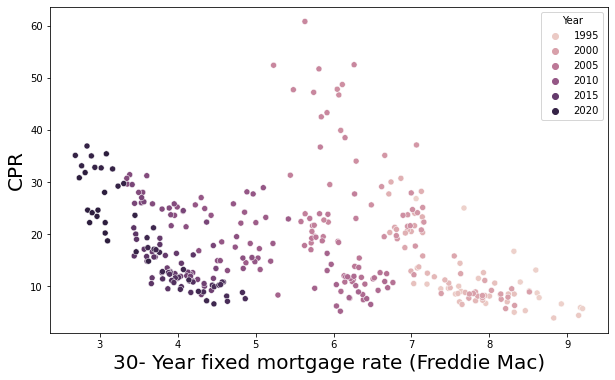

In [49]:
fig = plt.gcf()
fig.set_size_inches(10, 6)
p = sns.scatterplot(data=MonthlyCPR94to21, x="Fred30YrAvG", y="FN30CPR", hue = "Year")
p.set_xlabel("30- Year fixed mortgage rate (Freddie Mac)", fontsize = 20)
p.set_ylabel("CPR", fontsize = 20)

## 1. (a. ii) S - Curve: 1994 - 2021

The below plot shows, for each month from 1994 - 2021:
 - the refinance incentive, computed using Freddie Mac's 30 - year fixed mortgage rate and the WAC supplied by US Bank, and 
 - the corresponding CPR provided by US Bank. 
 
Importantly, we see that as refinance incentive becomes negative, the CPR levels off at about 10.

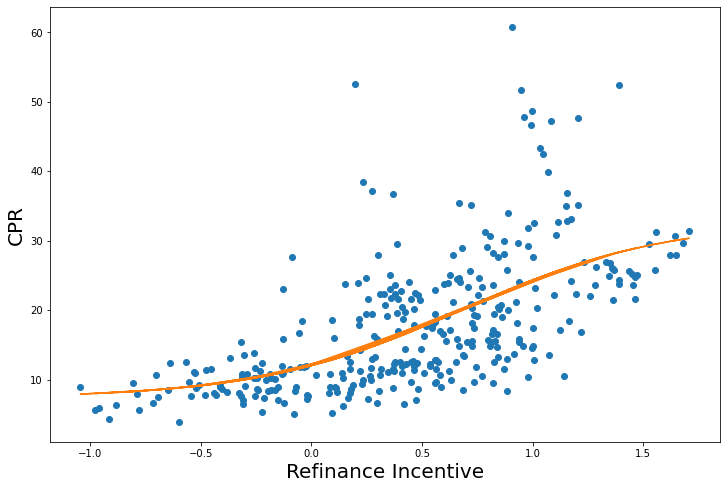

In [55]:
x = MonthlyCPR94to21["incentive_fred"]
y = MonthlyCPR94to21["FN30CPR"]

def f(x, a, b, c, d):
    return a / (1. + np.exp(-c * (x - d))) + b

popt, pcov = opt.curve_fit(f, x, y, method="trf")
y_fit = f(x, *popt)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(x, y, 'o')
ax.plot(x, y_fit, '-')
plt.xlabel("Refinance Incentive", fontsize = 20)
plt.ylabel("CPR", fontsize = 20)
plt.show()

## 1 (b. i) Mortgage vs. CPR (2015 - 2021)

The below plot shows, for each month from 2015 - 2021, the 30 - year mortgage rate, as provided by Optimal Blue, and a corresponding CPR provided by US Bank. There is a strong negative trend, likely due to reduced refinance-CPR as interests rates rise. A linear regression provides an R-squared score of 0.820 with a slope of -11.814 CPR per additional mortgage percentage point.

Text(0, 0.5, 'CPR')

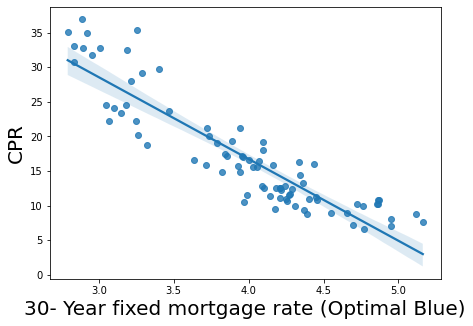

In [62]:
fig = plt.gcf()
fig.set_size_inches(7, 5)
p = sns.regplot(MonthlyCPR15to21['Optimal_Blue_Rate'], MonthlyCPR15to21['FN30CPR'])
p.set_xlabel("30- Year fixed mortgage rate (Optimal Blue)", fontsize = 20)
p.set_ylabel("CPR", fontsize = 20)

## 1. (a. ii) S - Curve: 2015 - 2021

The below plot shows, for each month from 2015 - 2021:
 - the refinance incentive, computed using Optimal Blue's 30 - year fixed mortgage rate and the WAC supplied by US Bank, and 
 - the corresponding CPR provided by US Bank. 

The S-curve is a better fit in this date range than in the previous S-curve for 1994-2021.

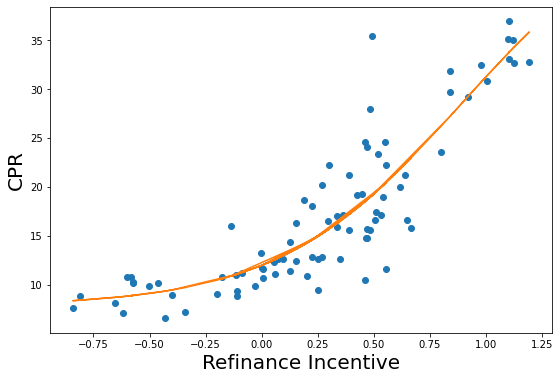

In [64]:
x = MonthlyCPR15to21["incentive_OB"]
y = MonthlyCPR15to21["FN30CPR"]

def f(x, a, b, c, d):
    return a / (1. + np.exp(-c * (x - d))) + b

popt, pcov = opt.curve_fit(f, x, y, method="trf")
y_fit = f(x, *popt)
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax.plot(x, y, 'o')
ax.plot(x, y_fit, '-')
plt.xlabel("Refinance Incentive", fontsize = 20)
plt.ylabel("CPR", fontsize = 20)
plt.show()

# (2) Using HPI and Housing Credit Availability to predict turnover

In [57]:
MonthlyCPR15to21

,Date,FN30CPR,FN30WAC,FN30WALA,FN30WAM,Month,Year,Optimal_Blue_Rate,incentive_OB,OB_Rate_LowLTV_LowFICO,...,CPR_HighLTV_LowFICO,CPR_HighLTV_HighFICO,WAC_LowLTV_LowFICO,WAC_LowLTV_HighFICO,WAC_HighLTV_LowFICO,WAC_HighLTV_HighFICO,incentive_LowLTV_LowFICO,incentive_LowLTV_HighFICO,incentive_HighLTV_LowFICO,incentive_HighLTV_HighFICO
89,2015-01-01,11.6,4.54,41,312,1,2015,3.987400,0.552600,4.365050,...,3.850608,9.046153,4.244573,3.788112,4.550262,4.104322,-0.120477,-0.050388,0.111512,0.126772
88,2015-02-01,15.6,4.54,41,312,2,2015,4.054789,0.485211,4.420316,...,3.950400,14.662869,4.241732,3.792748,4.536822,4.106099,-0.178584,-0.108673,0.059032,0.084625
87,2015-03-01,19.2,4.52,42,312,3,2015,4.094591,0.425409,4.425045,...,7.749426,16.704255,4.237796,3.792115,4.530664,4.103307,-0.187249,-0.157340,0.083073,0.043671
86,2015-04-01,16.6,4.51,42,312,4,2015,4.002773,0.507227,4.335000,...,12.485805,12.326114,4.223291,3.790940,4.511825,4.095267,-0.111709,-0.058651,0.133007,0.127131
85,2015-05-01,15.9,4.50,42,312,5,2015,4.163100,0.336900,4.471150,...,7.271809,12.526079,4.218045,3.780464,4.489869,4.087057,-0.253105,-0.239186,-0.049181,-0.040493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,2021-08-01,24.6,3.60,35,319,8,2021,3.048500,0.551500,3.308818,...,28.912720,27.003027,4.126317,3.399966,4.500551,3.449570,0.817499,0.470466,1.011324,0.440252
9,2021-09-01,24.1,3.57,35,319,9,2021,3.099762,0.470238,3.349619,...,22.689853,26.108463,4.109466,3.372452,4.476908,3.423966,0.759847,0.388547,0.951432,0.364490
8,2021-10-01,22.2,3.55,34,320,10,2021,3.251100,0.298900,3.481350,...,24.744651,23.300721,3.990839,3.283901,4.554887,3.401418,0.509489,0.139551,0.936937,0.195118
7,2021-11-01,20.2,3.53,34,320,11,2021,3.262737,0.267263,3.506842,...,25.744316,20.450905,3.973426,3.273404,4.526624,3.380993,0.466584,0.131140,0.850151,0.163835
